# Sandbox used for exploring data


In [141]:
%matplotlib inline

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config

from data.database import Database
from data.api_manager import API_Manager
from utils.descriptive_stats import weighted_mean

db = Database(config.database)
api = API_Manager(config.api_key)

## Trades

### What time window should the target variable be reduced to?

The vast majority of trades happend within regular hours. Most price changes also happens within this time. Anything outside Robinhood's extended hours can easily be trimmed off.

The fastest changes happen at the scale of seconds, whereas slower changes happen at the scale of minutes. No large changes seem to happen at the timescale of millisecond, so a window of 1 second would probably suffice.

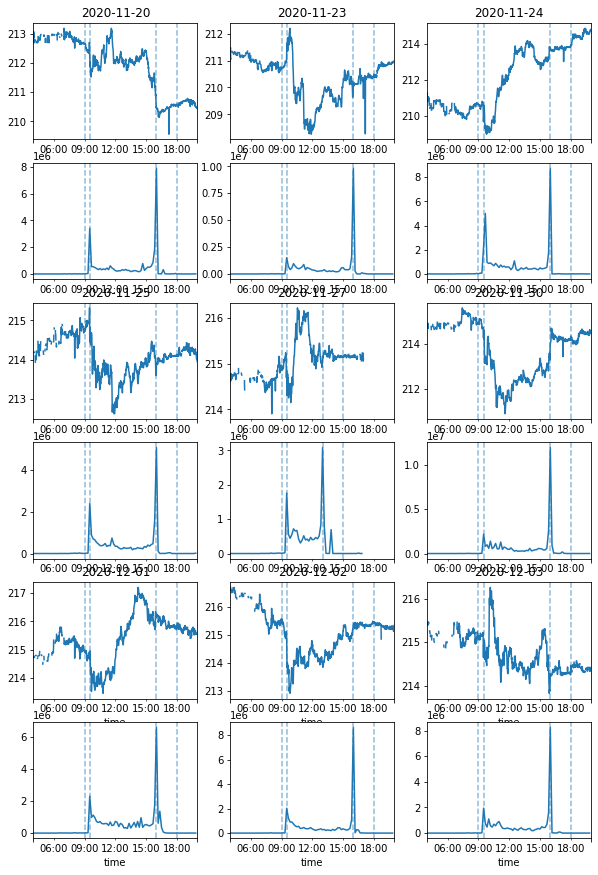

In [33]:
ticker = 'MSFT'
exchange = db.get_ticker_details(ticker)['exchange']

stored_dates = sorted(db.get_stored_dates('trades', ticker))

# Determine which hours the exchange is open, and which are before/after hours.
holidays = dict(db.get_holidays(exchange))
hours = {}
for date in stored_dates:
    hours[date] = {
        'open': datetime.time(9, 30), 
        'pre-open': datetime.time(9, 0),
        'close': datetime.time(16, 0),
        'post-close': datetime.time(18, 0),
    }
    if date in holidays and holidays[date] == 'half':
        hours[date]['close'] = datetime.time(13, 0)
        hours[date]['post-close'] = datetime.time(15, 0)



fig, axes = plt.subplots(6, 3, figsize=(10, 15))
for i in range(0, 9):
    date = stored_dates[len(stored_dates) - 10 + i]
    
    
    ax_price = axes[int(i/3)*2, i%3]
    ax_volume = axes[int(i/3)*2+1, i%3]
    
    trades = db.get_trades(ticker, date)
    trades = pd.DataFrame(trades, columns=['timestamp', 'price', 'volume'])
    trades['time'] = pd.to_datetime(trades['timestamp']) \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('America/New_York') 
        
    
    trades.groupby(pd.Grouper(key='time', freq='1min'))['price'].mean().plot.line(ax=ax_price)
    trades.groupby(pd.Grouper(key='time', freq='10min'))['volume'].sum().plot.line(ax=ax_volume)
    
    ax_price.set_title(date)
    for ax in (ax_price, ax_volume):
        ax.set_xlim(
            datetime.datetime.combine(date, datetime.time(4, 0)),
            datetime.datetime.combine(date, datetime.time(20, 0)),
        )
        if i < 6:
            ax.set_xlabel('')
    
        for time in hours[date].values():
            ax.axvline(
                datetime.datetime.combine(date, time), 
                linestyle='--', alpha=0.5
            )

## When to buy?

No handles with labels found to put in legend.
No handles with labels found to put in legend.


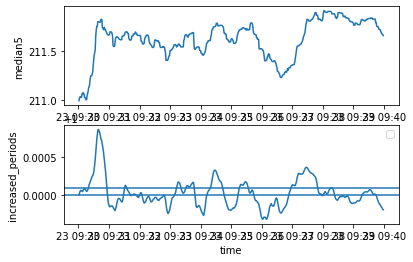

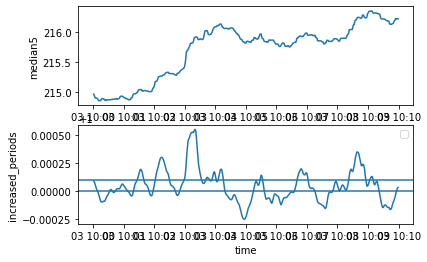

In [172]:
ticker = 'MSFT'


examples = [
    (datetime.date(2020, 11, 23), datetime.time(9, 30), datetime.time(9, 40)),
    (datetime.date(2020, 12, 3), datetime.time(10, 0), datetime.time(10, 10)),
]


for date, time_start, time_end in examples:

    trades = db.get_trades(ticker, date)

    grouper = pd.Grouper(key='time', freq='1S')
    mean_per_second = trades.groupby(grouper)['price'].mean()
    mean_weighted_per_second = weighted_mean(trades, 'price', 'volume', grouper)
    
    
    price = mean_per_second.to_frame().fillna(method='ffill')
    price['median5'] = price['price'].rolling(5, center=True).median()
    price['increase'] = price['median5'] / price['median5'].shift(5)
    price['increased_periods'] = price['increase'].rolling(20).mean()
    
#     price['increase_cat'] = -1
#     price.loc[price['increase'] > 1, 'increase_cat'] = 0
#     price.loc[price['increase'] > 1.001, 'increase_cat'] = 1
    
    
    fig, ax = plt.subplots(2, 1)
    
    price = price[(price.index.time > time_start) & (price.index.time < time_end)]
    
    sns.lineplot(ax=ax[0], data=price, x='time', y='median5')
    sns.lineplot(ax=ax[1], data=price, x='time', y='increased_periods')
    plt.axhline(1.0001)
    plt.axhline(1)
    

    plt.legend()


#     grouper = pd.Grouper(key='time', freq='1S')
#     trades_grouped = trades.groupby(grouper)
    
#     price_stats = trades_grouped['price'].agg(
#         ['count', 'mean', 'median', 'min', 'max', 'std']
#     )
#     price_mean_weighted = weighted_mean(trades, 'price', 'volume', grouper)
    

1199